In [1]:
import pandas as pd
import numpy as np
from joblib import parallel_backend

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier

class HyperparameterTuningGenetic:
    NUM_FOLDS = 5
    
    def __init__(self, randomSeed):
        self.randomSeed = randomSeed
        self.init_data()
        self.kfold = KFold(
            n_splits=self.NUM_FOLDS,
            random_state=self.randomSeed,
            shuffle=True
        )
    
    def init_data(self):
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
        
        self.data = pd.read_csv(url, header=None, usecols=range(0, 14))
        self.X = self.data.iloc[:, 1:14]
        self.y = self.data.iloc[:, 0]
    
    def convertParams(self, params):
        n_estimators = round(params[0]) # Converts to nearest integer
        learning_rate = params[1]
        algorithm = ['SAMME', 'SAMME.R'][round(params[2])] # Converts to nearest integer
        return n_estimators, learning_rate, algorithm
    
    def getAccuracy(self, params):
        
        with parallel_backend("threading"):
            n_estimators, learning_rate, algorithm = self.convertParams(params)
            self.classifier = AdaBoostClassifier(
                random_state=self.randomSeed,
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                algorithm=algorithm
            )
        
            cv_results = cross_val_score(
                self.classifier,
                self.X,
                self.y,
                cv=self.kfold,
                scoring='accuracy'
            )
            
            return cv_results.mean()
        
    def formatParams(self, params):
        return "'n_estimators'=%3d, 'learning_rate'=%1.3f, 'algorithm'=%s" % (self.convertParams(params))

In [2]:
from deap import base, creator, tools, algorithms

import numpy as np, random
import matplotlib.pyplot as plt
import seaborn as sns

toolbox = base.Toolbox()

POPULATION_SIZE = 50
P_CROSSOVER = 0.9
P_MUTATION = 0.2
MAX_GENERATIONS = 30
HALL_OF_FAME_SIZE = 5
CROWDING_FACTOR = 20.0

BOUNDS_LOW = [1, 0.01, 0]
BOUNDS_HIGH = [100, 1.00, 1]

NUM_OF_PARAMS = len(BOUNDS_HIGH)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
test = HyperparameterTuningGenetic(RANDOM_SEED)

In [3]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [4]:
# Fitness strategy
creator.create(
    "FitnessMax", 
    base.Fitness,
    weights=(1.0,)
)

# Individual list
creator.create(
    "Individual", 
    list, 
    fitness=creator.FitnessMax
)

# Generate a random float operator for each hyperparameter
for i in range(NUM_OF_PARAMS):
    toolbox.register(
        "hyperparameter_" + str(i),
        random.uniform,
        BOUNDS_LOW[i],
        BOUNDS_HIGH[i]
    )

# Store hyperparameters into tuple
hyperparameters = ()
for i in range(NUM_OF_PARAMS):
    hyperparameters += (toolbox.__getattribute__("hyperparameter_" + str(i)),)

# Population Generator
toolbox.register(
    "individualCreator",
    tools.initCycle,
    creator.Individual,
    hyperparameters,
    n=1
)

toolbox.register(
    "populationCreator",
    tools.initRepeat,
    list,
    toolbox.individualCreator
)

# Evaluation
def classificationAccuracy(individual):
    with parallel_backend("threading"):
        return test.getAccuracy(individual),

toolbox.register(
    "evaluate", 
    classificationAccuracy
)

# Selection
toolbox.register(
    "select",
    tools.selTournament,
    tournsize=2
)

# Crossover
toolbox.register(
    "mate",
    tools.cxSimulatedBinaryBounded,
    low=BOUNDS_LOW,
    up=BOUNDS_HIGH,
    eta=CROWDING_FACTOR
)

# Mutation
toolbox.register(
    "mutate",
    tools.mutPolynomialBounded,
    low=BOUNDS_LOW,
    up=BOUNDS_HIGH,
    eta=CROWDING_FACTOR,
    indpb=1.0/NUM_OF_PARAMS
)

gen	nevals	max     	avg     
0  	50    	0.977619	0.938384
1  	41    	0.977619	0.947473
2  	42    	0.977619	0.961746
3  	44    	0.977619	0.965702
4  	44    	0.983016	0.968041
5  	33    	0.983016	0.970949
6  	40    	0.983016	0.971365
7  	43    	0.983016	0.972933
8  	38    	0.98873 	0.976038
9  	44    	0.98873 	0.974556
10 	36    	0.98873 	0.977556
11 	38    	0.98873 	0.980156
12 	42    	0.98873 	0.979686
13 	34    	0.98873 	0.984168
14 	43    	0.98873 	0.98341 
15 	40    	0.98873 	0.987137
16 	42    	0.98873 	0.986597
17 	41    	0.98873 	0.986489
18 	40    	0.98873 	0.984346
19 	42    	0.98873 	0.984025
20 	38    	0.98873 	0.985368
21 	42    	0.98873 	0.984924
22 	39    	0.98873 	0.985362
23 	43    	0.98873 	0.986603
24 	39    	0.98873 	0.985927
25 	40    	0.98873 	0.988616
26 	40    	0.98873 	0.98413 
27 	42    	0.98873 	0.987492
28 	43    	0.98873 	0.985254
29 	43    	0.98873 	0.985254
30 	43    	0.98873 	0.9848  
- Best solution:
params = 'n_estimators'= 87, 'learning_rate'=0.877, 'al

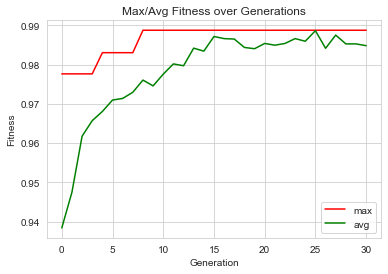

In [5]:
def GA():
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    
    population, logbook = eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True
    )
    
    print("- Best solution:")
    print("params =", test.formatParams(hof.items[0]))
    print("Accuracy = %1.5f" % hof.items[0].fitness.values[0])
    
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red', label='max')
    plt.plot(meanFitnessValues, color='green', label='avg')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Max/Avg Fitness over Generations")
    plt.legend()
    plt.show()

GA()